## Homework

> **Note**: it's very likely that in this homework your answers won't match 
> the options exactly. That's okay and expected. Select the option that's
> closest to your solution.
> If it's exactly in between two options, select the higher value.

### Dataset

In this homework, we'll build a model for classifying various hair types. 
For this, we will use the Hair Type dataset that was obtained from 
[Kaggle](https://www.kaggle.com/datasets/kavyasreeb/hair-type-dataset) 
and slightly rebuilt.

You can download the target dataset for this homework from 
[here](https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip):

```bash
wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
unzip data.zip
```

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

We will use PyTorch for that.

You can use Google Colab or your own computer for that.

### Data Preparation

The dataset contains around 1000 images of hairs in the separate folders 
for training and test sets. 

In [1]:
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip data.zip

--2025-11-23 19:54:44--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-23T19%3A40%3A49Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-23T18%3A40%3A13Z&ske=2025-11-23T19%3A40%3A49Z&sks=b&skv=2018-11-09&sig=cDl9uV3%2Fengb4jUZVZQy6XvHVu1llv5w5NClG7rhS08%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2MzkyNTg4NSwibmJmIjoxNzYzOTI0MDg1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

torch.backends.mps.is_available()

True

### Reproducibility

Reproducibility in deep learning is a multifaceted challenge that requires attention 
to both software and hardware details. In some cases, we can't guarantee exactly the same results during the same experiment runs.

Therefore, in this homework we suggest to set the random number seed generators by:

In [2]:
# Set random seeds for reproducibility on CPU and MPS (Apple Silicon)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# MPS (Apple Silicon) doesn't have cuda manual seed, so just check for MPS
if torch.backends.mps.is_available():
    # No specific manual seed function for MPS — 
    # torch.manual_seed already covers it
    pass

# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)
#     torch.cuda.manual_seed_all(SEED)
    
# cuDNN settings do not apply on MPS, but keeping them doesn’t break anything
# they simply won't be used.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Device:", "mps" if torch.backends.mps.is_available() else "cpu")


Device: mps


### Model

For this homework we will use Convolutional Neural Network (CNN). We'll use PyTorch.

You need to develop the model with following structure:

* The shape for input should be `(3, 200, 200)` (channels first format in PyTorch)
* Next, create a convolutional layer (`nn.Conv2d`):
    * Use 32 filters (output channels)
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling (`nn.MaxPool2d`)
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using `flatten` or `view`
* Next, add a `nn.Linear` layer with 64 neurons and `'relu'` activation
* Finally, create the `nn.Linear` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `torch.optim.SGD` with the following parameters:

* `torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)`


### Question 1

Which loss function you will use?

* `nn.MSELoss()`
* `nn.BCEWithLogitsLoss()`
* `nn.CrossEntropyLoss()`
* `nn.CosineEmbeddingLoss()`

(Multiple answered can be correct, so pick any)
- `nn.BCEWithLogitsLoss()`

In [3]:
# Define the model
class HairNet(nn.Module):
    def __init__(self):
        super(HairNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # We must calculate flatten size:
        # Input: (3, 200, 200)
        # After Conv2d(kernel=3, padding=0): (32, 198, 198)
        # After MaxPool2d(2): (32, 99, 99)
        flatten_size = 32 * 99 * 99
        
        self.fc = nn.Sequential(
            nn.Linear(flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # final output
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = HairNet()


### Question 2

What's the total number of parameters of the model? You can use `torchsummary` or count manually. 

In PyTorch, you can find the total number of parameters using:

```python
# Option 1: Using torchsummary (install with: pip install torchsummary)
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

# Option 2: Manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
```

* 896 
* 11214912
* 15896912
* 20073473

In [4]:
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

20073473


### Generators and Training

For the next two questions, use the following transformation for both train and test sets:

```python
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])
```

* We don't need to do any additional pre-processing for the images.
* Use `batch_size=20`
* Use `shuffle=True` for both training, but `False` for test. 

Now fit the model.

You can use this code:

```python
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}"))
```

In [5]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Datasets
train_dataset = datasets.ImageFolder(root='./data/data_hair/train', transform=train_transforms)
val_dataset   = datasets.ImageFolder(root='./data/data_hair/test', transform=val_transforms)

# DataLoaders
batch_size = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# Training setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)
num_epochs = 10

history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6462, Acc: 0.6362, Val Loss: 0.6032, Val Acc: 0.6517
Epoch 2/10, Loss: 0.5475, Acc: 0.7100, Val Loss: 0.7251, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5533, Acc: 0.7250, Val Loss: 0.5991, Val Acc: 0.6716
Epoch 4/10, Loss: 0.4802, Acc: 0.7712, Val Loss: 0.6033, Val Acc: 0.6567
Epoch 5/10, Loss: 0.4334, Acc: 0.8025, Val Loss: 0.6196, Val Acc: 0.6766
Epoch 6/10, Loss: 0.3740, Acc: 0.8325, Val Loss: 0.7371, Val Acc: 0.6766
Epoch 7/10, Loss: 0.2721, Acc: 0.8838, Val Loss: 0.9223, Val Acc: 0.6418
Epoch 8/10, Loss: 0.2478, Acc: 0.9000, Val Loss: 0.7294, Val Acc: 0.7214
Epoch 9/10, Loss: 0.2075, Acc: 0.9200, Val Loss: 0.7523, Val Acc: 0.7015
Epoch 10/10, Loss: 0.1494, Acc: 0.9450, Val Loss: 0.7894, Val Acc: 0.7015


### Question 3

What is the median of training accuracy for all the epochs for this model?

* 0.05
* 0.12
* 0.40
* 0.84 <<--

In [7]:
# Calculate median training accuracy
median_acc = np.median(history['acc'])
print("Median training accuracy:", median_acc)

Median training accuracy: 0.8175



### Question 4

What is the standard deviation of training loss for all the epochs for this model?

* 0.007
* 0.078
* 0.171 <<--
* 1.710

In [8]:
# Calculate standard deviation of training loss
std_loss = np.std(history['loss'])
print("Standard deviation of training loss:", std_loss)

Standard deviation of training loss: 0.15896660177425864


### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

```python
transforms.RandomRotation(50),
transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
transforms.RandomHorizontalFlip(),
```

In [9]:
# New train transforms with augmentation
train_transforms_aug = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Update the dataset and DataLoader
train_dataset_aug = datasets.ImageFolder(root='./data/data_hair/train', transform=train_transforms_aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=20, shuffle=True)


In [10]:
# Training setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)
num_epochs = 10

history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.7251, Acc: 0.6362, Val Loss: 0.6326, Val Acc: 0.6965
Epoch 2/10, Loss: 0.5791, Acc: 0.6713, Val Loss: 0.7981, Val Acc: 0.6766
Epoch 3/10, Loss: 0.5541, Acc: 0.7275, Val Loss: 0.6343, Val Acc: 0.7065
Epoch 4/10, Loss: 0.5366, Acc: 0.7113, Val Loss: 0.5753, Val Acc: 0.7065
Epoch 5/10, Loss: 0.5520, Acc: 0.7113, Val Loss: 0.6179, Val Acc: 0.6716
Epoch 6/10, Loss: 0.5019, Acc: 0.7588, Val Loss: 0.5727, Val Acc: 0.7313
Epoch 7/10, Loss: 0.5291, Acc: 0.7412, Val Loss: 0.7469, Val Acc: 0.6517
Epoch 8/10, Loss: 0.4881, Acc: 0.7600, Val Loss: 0.9619, Val Acc: 0.6418
Epoch 9/10, Loss: 0.5050, Acc: 0.7512, Val Loss: 0.5238, Val Acc: 0.7313
Epoch 10/10, Loss: 0.4591, Acc: 0.7863, Val Loss: 0.5285, Val Acc: 0.7562


### Question 5 

Let's train our model for 10 more epochs using the same code as previously.

> **Note:** make sure you don't re-create the model.
> we want to continue training the model we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.008
* 0.08
* 0.88 <<--
* 8.88

In [11]:
# Calculate meann of validation loss
mean_val_loss = np.mean(history['val_loss'])
print("Mean validation/test loss:", mean_val_loss)

Mean validation/test loss: 0.6592007767353485


### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.08
* 0.28
* 0.68 <<--
* 0.98

In [12]:
# Calculate average of last 5 validation accuracies
last_5_val_acc = history['val_acc'][-5:]  # last 5 epochs
avg_last_5_val_acc = np.mean(last_5_val_acc)
print("Average validation/test accuracy (last 5 epochs):", avg_last_5_val_acc)

Average validation/test accuracy (last 5 epochs): 0.7024875621890547


## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw08
* If your answer doesn't match options exactly, select the closest one. If the answer is exactly in between two options, select the higher value.

Predicting a single image

In [ ]:
# Save the model
torch.save(model.state_dict(), "hairnet.pth")

In [14]:
# Load model
model = HairNet()
model.load_state_dict(torch.load("hairnet.pth", map_location=device))
model.to(device)
model.eval()

HairNet(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=313632, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [24]:
# Image preprocessing
from PIL import Image
import torchvision.transforms as transforms
import torch

# Same transforms as training (resize + ToTensor + normalize)
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load your image
img = Image.open("./data/data_hair/test/curly/image270.jpg").convert("RGB")
img_t = transform(img)
img_t = img_t.unsqueeze(0)  # add batch dimension: (1, 3, 200, 200)
img_t = img_t.to(device)


In [27]:
# predict
with torch.no_grad():
    output = model(img_t)
    prob = torch.sigmoid(output).item()  # probability of straight hair
    pred = (prob > 0.5)                  # 0 or 1

print(f"Probability of straight hair: {prob:.2%}")
print(f"Probability of curly hair: {100 - prob*100:.2f}%")
print(f"Predicted class: {int(pred)}")  # 0 = curly, 1 = straight


Probability of straight hair: 37.94%
Probability of curly hair: 62.06%
Predicted class: 0


In [ ]:
# Get class names
class_names = train_dataset.classes  # ['curly', 'straight']
print(f"Predicted label: {class_names[int(pred.item())]}")

Predicted label: curly


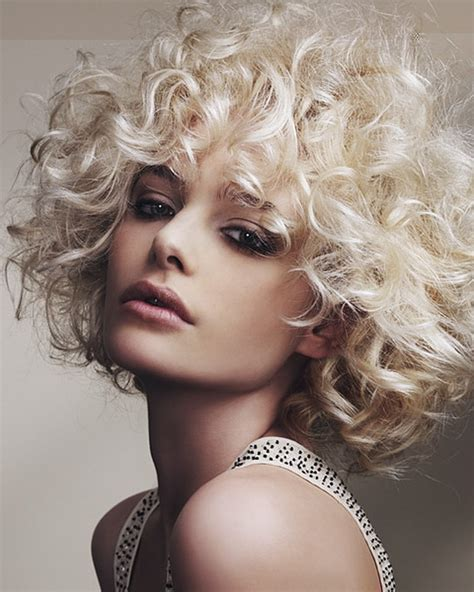

In [ ]:
from IPython.display import display
# reading an image with PIL
img = Image.open("./data/data_hair/test/curly/image270.jpg")
# img.show()
display(img)